In [1]:
import numpy as np
import matplotlib.pyplot as plt
from time import time
import itertools
import os
import random
from PIL import Image

# to see the resized version of images
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader


In [2]:
trainX = np.load('trainX.npy')
trainY = np.load('trainY.npy')
testX = np.load('testX.npy')
testY = np.load('testY.npy')

trainY = trainY.astype(int)
testY = testY.astype(int)

with open("testPaths.txt", "r") as f:
    testPaths = f.read().strip().split("\n")

with open("trainPaths.txt", "r") as f:
    trainPaths = f.read().strip().split("\n")

print(f"shape of trainX is : {trainX.shape}")
print(f"shape of trainY is : {trainY.shape}")
print(f"shape of testX is : {testX.shape}")
print(f"shape of testY is : {testY.shape}")
print(f"length of trainPaths is : {len(trainPaths)}")
print(f"length of testPaths is : {len(testPaths)}")

shape of trainX is : (18192, 4096)
shape of trainY is : (18192, 1)
shape of testX is : (4551, 4096)
shape of testY is : (4551, 1)
length of trainPaths is : 18192
length of testPaths is : 4551


In [3]:
class LogisticRegression:
    
    def __init__(self, lr, epochs):
        self.lr = lr
        self.epochs = epochs
        self.weights = None
        self.bias = None
    
    def fit(self, features, labels, test_features, test_labels):
    
        numberOfSamples , numberOfFeatures = features.shape
        numberOfClasses = len(np.unique(labels))
        
        
        self.weights = 0.01 * np.random.rand(numberOfFeatures, numberOfClasses)
        self.bias = 0.01 * np.random.rand(numberOfClasses) * 0.01
                
        targets = np.zeros(shape = [numberOfSamples, numberOfClasses])
        targets[np.arange(numberOfSamples), labels.T] = 1
        
        test_targets = np.zeros(shape = [len(test_features), numberOfClasses])
        test_targets[np.arange(len(test_features)), test_labels.T] = 1
        
        print("Starting to train.")
        print("-----------------")
        loss_history_training = []
        loss_history_test = []

        for i in range(self.epochs):
            
            scores = np.dot(features, self.weights) + self.bias
            
            outputs = self.softmax(scores)

            d_error = outputs - targets
            
            dw = (1 / numberOfSamples) * np.dot(features.T, d_error)
            db = (1 / numberOfSamples) * np.sum(d_error, axis = 0)
            
            self.weights -= self.lr * dw
            self.bias -= self.lr * db
            
            loss = np.sum(self.categorical_cross_entropy_loss(targets, outputs))
            
            
            test_scores = np.dot(test_features, self.weights) + self.bias
            test_outputs = self.softmax(test_scores)
            test_loss = np.sum(self.categorical_cross_entropy_loss(test_targets, test_outputs))

            loss_history_training.append(loss/numberOfSamples)
            loss_history_test.append(test_loss/len(test_features))

            if i == 0 or (i - 9) % 10 == 0:
                print(f"epoch: {i+1}/{self.epochs} , loss: {loss/numberOfSamples:.2f}, training accuracy: {self.evaluate(targets, outputs):.2f}")
        
        return loss_history_training, loss_history_test
        
    # predict 1 sample
    def predict(self, features):
        scores = np.dot(features, self.weights) + self.bias
        probabilities = self.softmax(scores)
        label = np.argmax(probabilities)
        confidence = probabilities[0][label]
        return label, confidence
        
    def softmax(self, x):
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum(axis=1, keepdims=True)
    
    def categorical_cross_entropy_loss(self, targets, outputs):
        return -np.sum(targets * np.log(outputs), axis = 1)
    
    def evaluate(self, targets, outputs):
        return np.mean(np.argmax(targets, axis=1) == np.argmax(outputs, axis=1))
    

In [4]:
learning_rate = 0.001
epochs = 100

model = LogisticRegression(learning_rate, epochs)
before = time()
history_train, history_test = model.fit(trainX, trainY, testX, testY)
    
print("-----------------")
print(f"time elapsed: {time() - before:.2f} seconds ")

Starting to train.
-----------------
epoch: 1/100 , loss: 2.35, training accuracy: 0.16
epoch: 10/100 , loss: 0.83, training accuracy: 0.90
epoch: 20/100 , loss: 0.56, training accuracy: 0.92
epoch: 30/100 , loss: 0.45, training accuracy: 0.93
epoch: 40/100 , loss: 0.39, training accuracy: 0.93
epoch: 50/100 , loss: 0.35, training accuracy: 0.93
epoch: 60/100 , loss: 0.33, training accuracy: 0.93
epoch: 70/100 , loss: 0.31, training accuracy: 0.93
epoch: 80/100 , loss: 0.29, training accuracy: 0.93
epoch: 90/100 , loss: 0.28, training accuracy: 0.94
epoch: 100/100 , loss: 0.27, training accuracy: 0.94
-----------------
time elapsed: 53.75 seconds 


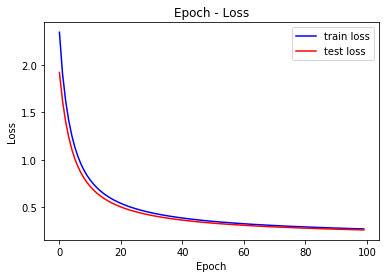

In [5]:
plt.plot(history_train, "-b", label="train loss")
plt.plot(history_test, "-r", label="test loss")
plt.title("Epoch - Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper right")

In [6]:
# test
classes = np.unique(trainY)
conf_matrix = np.zeros(shape=(len(classes),len(classes)))
for i, (features, label) in enumerate(zip(testX, testY)):
    rowMatrix = np.reshape(features, (1, len(features)))
    label = label[0]
    
    prediction, _ = model.predict(rowMatrix)
    conf_matrix[label][prediction] += 1

In [7]:
acc = correct / len(testX)
recall = np.mean(np.diag(conf_matrix) / np.sum(conf_matrix, axis = 1))
precision = np.mean(np.diag(conf_matrix) / np.sum(conf_matrix, axis = 0))

print(f"overall accuracy is {acc:.2f}")
print(f"overall precision is {precision:.2f}")
print(f"overall recall is {recall:.2f}")

overall accuracy is 0.94
overall precision is 0.94
overall recall is 0.94


In [8]:
# from scikitlearn 0.18 - old version
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix


<Figure size 432x288 with 0 Axes>

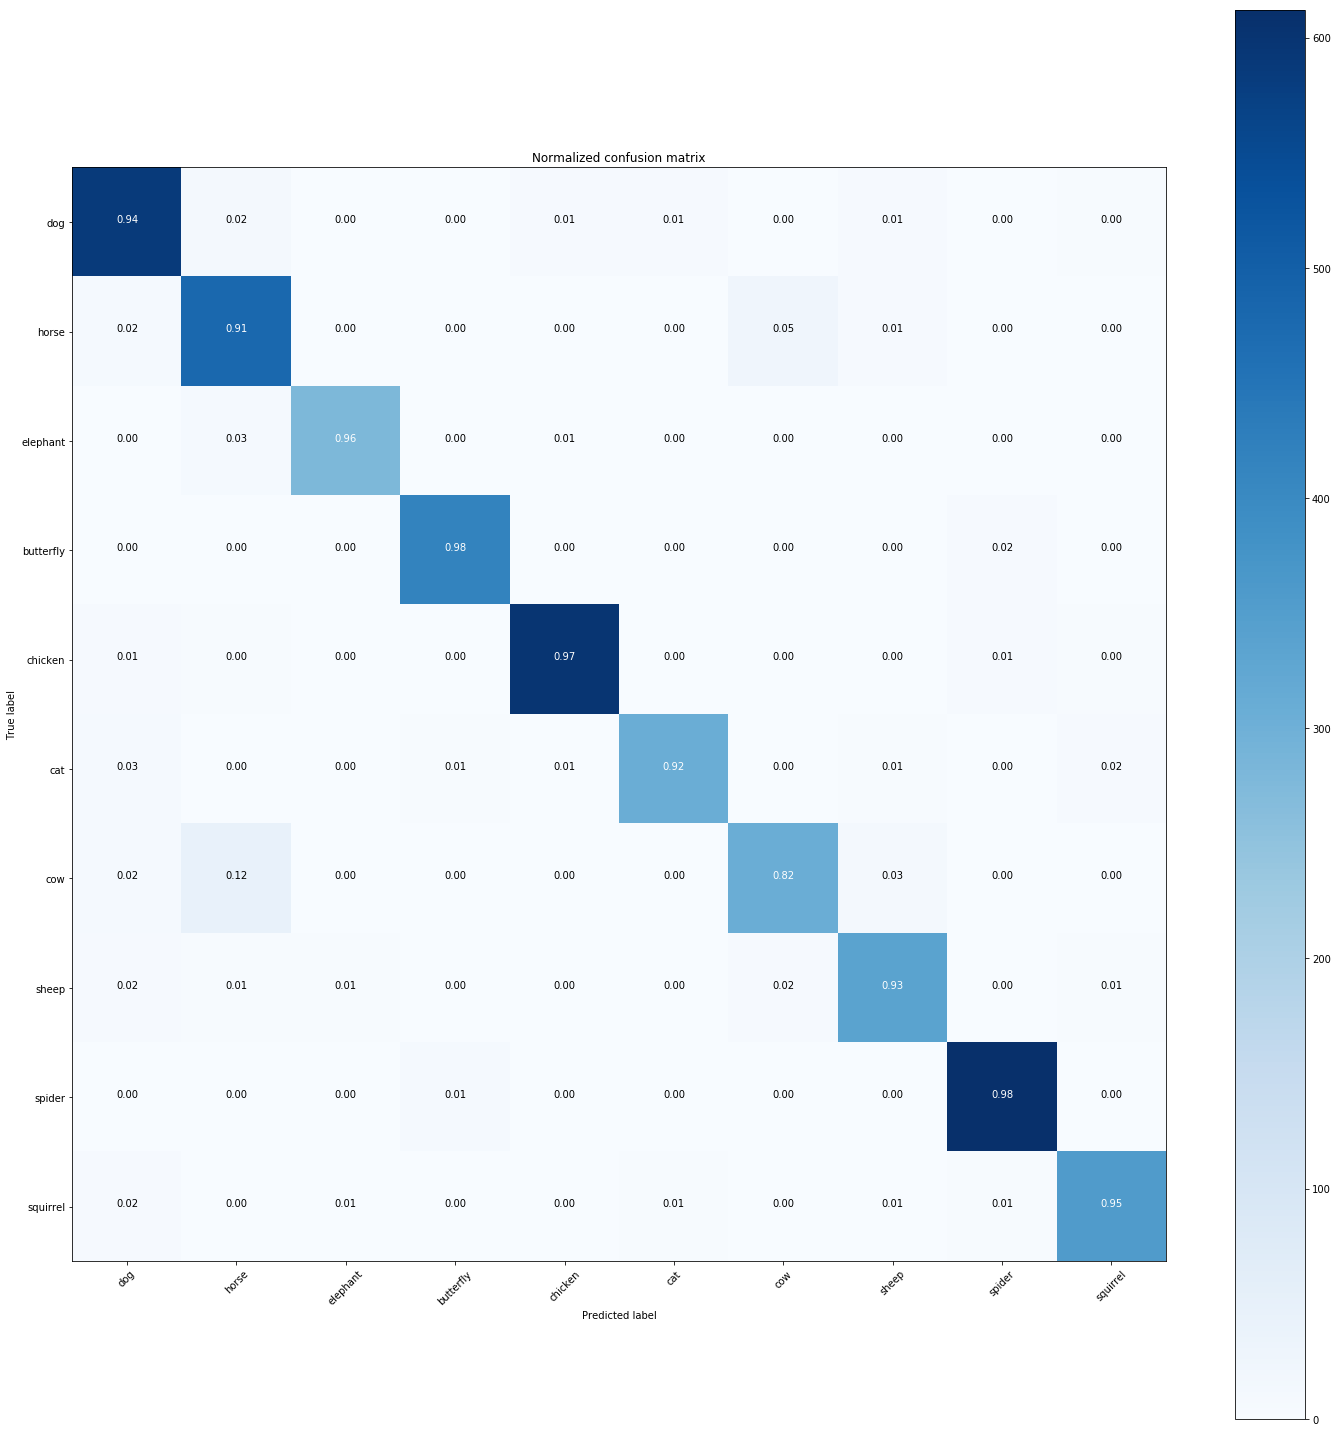

In [9]:
class_names = ["dog", "horse", "elephant", "butterfly", "chicken", "cat", "cow", "sheep", "spider","squirrel"]

plt.figure()
plt.figure(figsize=(20,20))

plot_confusion_matrix(conf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [10]:
# to free up memory
del trainX
del trainY

In [11]:
vggModel = models.vgg16(pretrained=True)
vggModel.classifier = nn.Sequential(*list(vggModel.classifier.children())[:-3])
input_size = 224
mean = [0.5177, 0.5003, 0.4126]
std = [0.2135, 0.2130, 0.2151]
tensor_transform = transforms.Compose([
            transforms.Resize((input_size,input_size)),
            transforms.ToTensor()])

In [12]:
numberToClass = {
                 0: "dog",
                 1: "horse",
                 2: "elephant",
                 3: "butterfly",
                 4: "chicken",
                 5: "cat",
                 6: "cow",
                 7: "sheep",
                 8: "spider",
                 9: "squirrel"
}

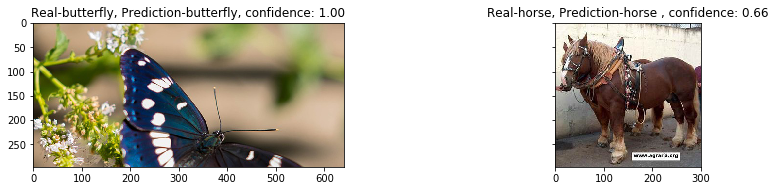

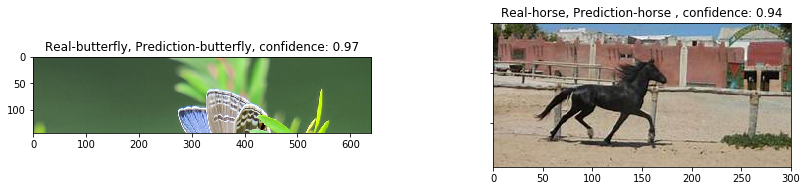

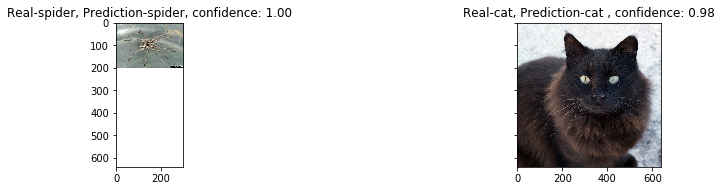

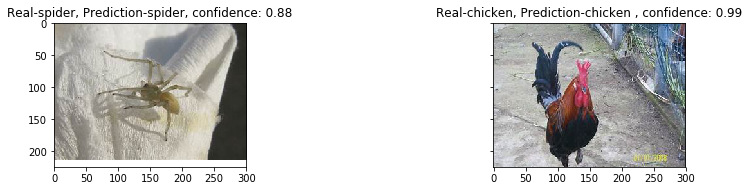

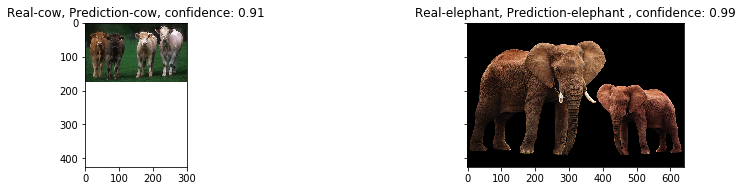

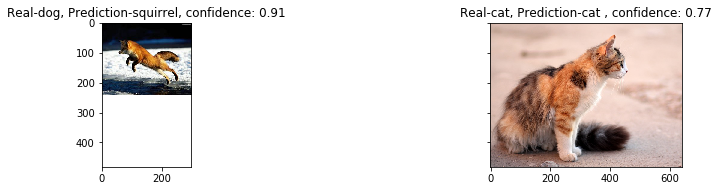

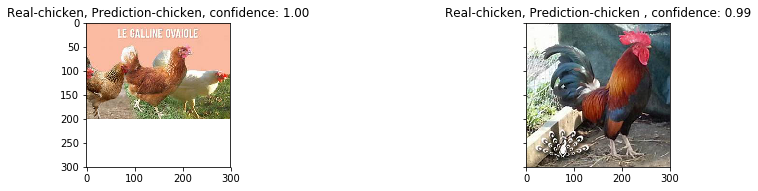

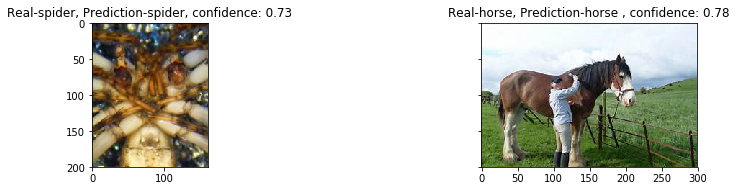

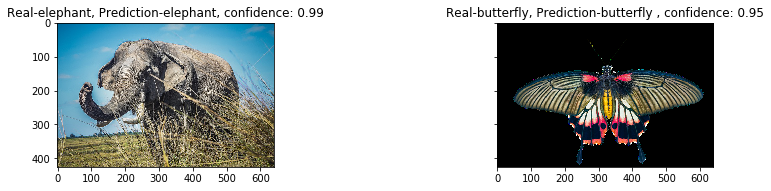

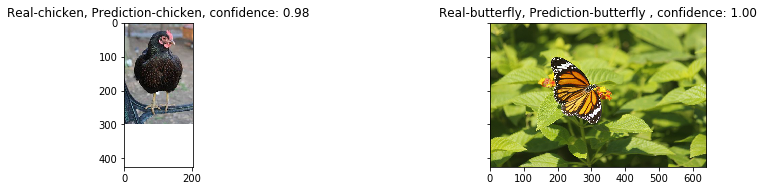

In [13]:
testNumber = 20
for i in range(int(testNumber/2)):
    randIndex1 = random.randint(0, len(testX) -1)
    randIndex2 = random.randint(0, len(testX) -1)

        
    im1 = Image.open(testPaths[randIndex1]).convert("RGB")
    im2 = Image.open(testPaths[randIndex2]).convert("RGB")

    
    features1 = testX[randIndex1]
    features1 = np.reshape(features1, (1, len(features1)))
                                              
    features2 = testX[randIndex2]
    features2 = np.reshape(features2, (1, len(features2)))
                                              
    label1 = testY[randIndex1][0]
    label2 = testY[randIndex2][0]


    
    prediction1, confidence1 = model.predict(features1)
    prediction2, confidence2 = model.predict(features2)

    
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    plt.subplots_adjust(left=0.0, bottom=0, right=1.8, top=0.5,wspace=0.3, hspace=0.3)

    ax1.imshow(im1)
    ax2.imshow(im2)
    ax1.set_title(f"Real-{numberToClass[label1]}, Prediction-{numberToClass[prediction1]}, confidence: {confidence1:.2f}")
    ax2.set_title(f"Real-{numberToClass[label2]}, Prediction-{numberToClass[prediction2]} , confidence: {confidence2:.2f}")

    plt.show() 

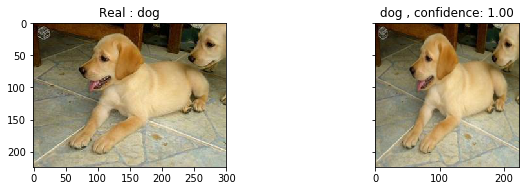

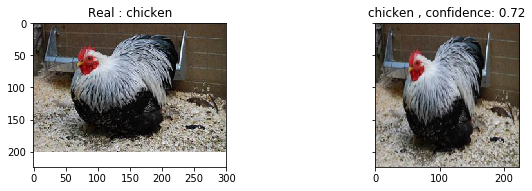

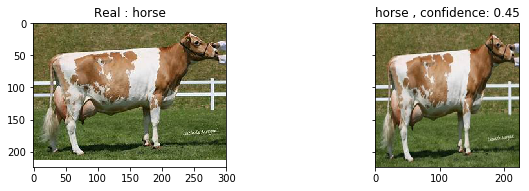

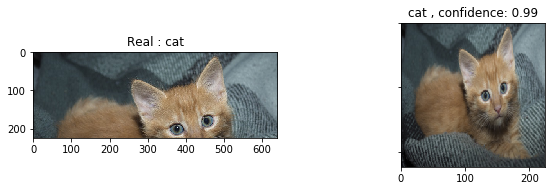

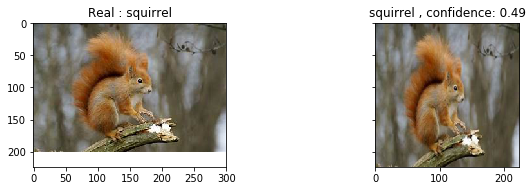

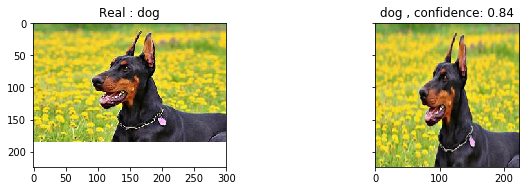

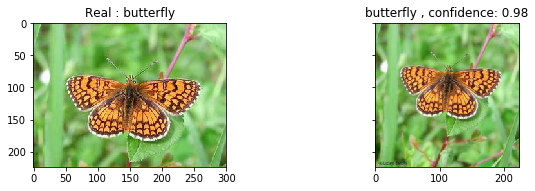

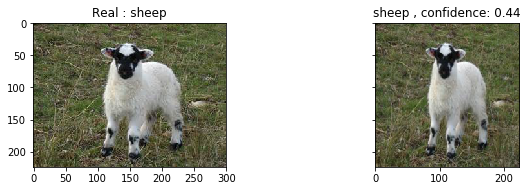

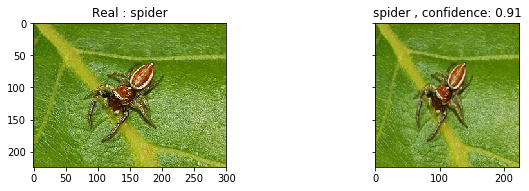

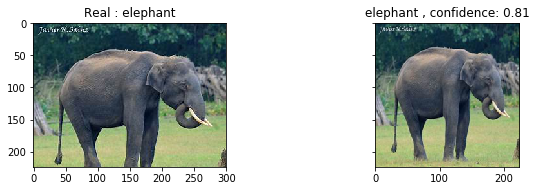

In [14]:
os.chdir("D:\\python\\animal classifier")


root_dir = os.getcwd()
testDir = os.path.join(root_dir, "plotImgs")
os.chdir(testDir)

file = open("labels.txt", "r")
labels = file.read().strip().split("-")

with torch.no_grad():
    for i in range(len(os.listdir())): # 1 file is txt file
        if f"{i+1}.jpg" in os.listdir():
            path = f"{i+1}.jpg"
                   
        elif f"{i+1}.jpeg" in os.listdir():
            path = f"{i+1}.jpeg"
                   
        else:
            continue

        imgPIL = Image.open(path) #PIL image
        imgTensor = tensor_transform(imgPIL) #torch.FloatTensor 3,224,224
        features = vggModel(imgTensor[None, ...])
        features = features.detach().numpy()  
        
        prediction, confidence = model.predict(features)
        
        f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
        plt.subplots_adjust(left=0.0, bottom=0, right=1.3, top=0.5,wspace=0.3, hspace=0.3)
        
        ax1.imshow(imgPIL)
        ax2.imshow( imgTensor.permute(1, 2, 0) )
        ax1.set_title(f"Real : {numberToClass[prediction]}")
        ax2.set_title(f"{numberToClass[prediction]} , confidence: {confidence:.2f}")

        plt.show() 